In [1]:
# instalación de librerias y/o modulos

## Scipy
### Bajo pip -- python -m pip install scipy
### Bajo Conda -- conda install scipy

## sqlalchemy
### Bajo pip -- pip install SQLAlchemy
###             pip install sqlalchemy-utils
### Bajo Conda conda install -c anaconda sqlalchemy
###            conda install -c conda-forge sqlalchemy-utils


In [5]:

# Importaciones
import pandas as pd
import numpy as np
import scipy.stats as stats
from sqlalchemy import create_engine
import funciones as fx
from pandas import ExcelWriter
from matplotlib import pyplot as plt
import seaborn as sns
import missingno as msngo
from sinfo import sinfo

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, LassoCV, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor, BaggingRegressor
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error, median_absolute_error, r2_score, confusion_matrix

from lazypredict.Supervised import LazyRegressor
from pygam import LinearGAM, s
from sklearn.preprocessing import StandardScaler


sns.set(rc = {'figure.figsize':(20,12)})

In [6]:
# Informacion del sistema
sinfo()

The `sinfo` package has changed name and is now called `session_info` to become more discoverable and self-explanatory. The `sinfo` PyPI package will be kept around to avoid breaking old installs and you can downgrade to 0.3.2 if you want to use it without seeing this message. For the latest features and bug fixes, please install `session_info` instead. The usage and defaults also changed slightly, so please review the latest README at https://gitlab.com/joelostblom/session_info.
-----
funciones   NA
lazypredict 0.2.12
matplotlib  3.6.3
missingno   0.5.1
numpy       1.24.1
pandas      1.5.3
pygam       0.8.0
scipy       1.10.0
seaborn     0.12.2
sinfo       0.3.4
sisifo      0.1.1
sklearn     1.2.1
sqlalchemy  1.4.46
-----
IPython             8.9.0
jupyter_client      8.0.2
jupyter_core        5.2.0
-----
Python 3.10.6 (main, Nov 14 2022, 16:10:14) [GCC 11.3.0]
Linux-6.0.12-76060006-generic-x86_64-with-glibc2.35
16 logical CPU cores, x86_64
-----
Session information updated at 2023-02-

In [2]:
# Conexión a BD PostgreSQL
conn = fx.conexion_sqlalchemy()

#### Datos desde Bd postgres

In [3]:
# Creación de dataset de entrenamiento, testeo y EDA mediante función, la cual se conecta a BD PostgreSQL
df_train = fx.selectViewTrain(conn)
df_test = fx.selectViewTest(conn)
#df_complete = fx.selectViewComplete(conn)

#### Visaulizacion general dataframe

In [4]:
df_train.head()

,Id,Vin,Year,Price,Mileage,City,City_Id,State,State_Id,Make,...,Model_Id,Doors,Fuel_Type,Fuel_Id,Engine_Displacement_CC,Engine_Displacement_CI,Engine_Number_Cylinders,Transmission_Speeds,Gama,Gama_Id
0,1,19VDE1F52DE012636,2013,10888,19606,Long Island City,8923,NY,41,Acura,...,1226,4,gasoline,6,1997.00,121.90,4,5,generalista,1
1,2,19VDE1F71EE003817,2014,10999,39922,Windsor,10156,CO,8,Acura,...,1226,4,gasoline,6,1997.00,121.90,4,5,generalista,1
2,3,19UDE2F32GA001284,2016,14799,22142,Lindon,8893,UT,52,Acura,...,1229,4,gasoline,6,2359.74,144.00,4,8,generalista,1
3,4,JH4CU2F83CC019895,2012,7989,105246,Miami,9057,FL,13,Acura,...,2394,4,gasoline,6,2359.74,144.00,4,5,generalista,1
4,5,JH4CU2F64DC006203,2013,13995,32384,West Jordan,10092,UT,52,Acura,...,2393,4,gasoline,6,2359.74,144.00,4,5,generalista,1


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 618256 entries, 0 to 618255
Data columns (total 22 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Id                       618256 non-null  int64  
 1   Vin                      618256 non-null  object 
 2   Year                     618256 non-null  int64  
 3   Price                    618256 non-null  int64  
 4   Mileage                  618256 non-null  int64  
 5   City                     618256 non-null  object 
 6   City_Id                  618256 non-null  int64  
 7   State                    618256 non-null  object 
 8   State_Id                 618256 non-null  int64  
 9   Make                     618256 non-null  object 
 10  Make_Id                  618256 non-null  int64  
 11  Model                    618256 non-null  object 
 12  Model_Id                 618256 non-null  int64  
 13  Doors                    618256 non-null  int64  
 14  Fuel

In [6]:
df_test.head()

,Id,Vin,Year,Price,Mileage,City,City_Id,State,State_Id,Make,...,Model_Id,Doors,Fuel_Type,Fuel_Id,Engine_Displacement_CC,Engine_Displacement_CI,Engine_Number_Cylinders,Transmission_Speeds,Gama,Gama_Id
0,1,19VDE2E53EE000083,2014,8995,35725,El Paso,8307,TX,51,Acura,...,1227,4,gasoline,6,2354.00,144.00,4,6,generalista,1
1,2,19VDE2E52DE000025,2013,8995,48851,El Paso,8307,TX,51,Acura,...,1227,4,gasoline,6,2354.00,144.00,4,6,generalista,1
2,3,JH4CU2F84EC002686,2014,14490,34032,Greatneck,8550,NY,41,Acura,...,2397,4,gasoline,6,2359.74,144.00,4,5,generalista,1
3,4,JH4CU2F44CC003220,2012,12921,58550,Boise,7867,ID,19,Acura,...,2394,4,gasoline,6,2359.74,144.00,4,5,generalista,1
4,5,19VDE1F31EE009243,2014,14995,23454,Hackettstown,8583,NJ,38,Acura,...,1226,4,gasoline,6,1997.00,121.90,4,5,generalista,1


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206042 entries, 0 to 206041
Data columns (total 22 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Id                       206042 non-null  int64  
 1   Vin                      206042 non-null  object 
 2   Year                     206042 non-null  int64  
 3   Price                    206042 non-null  int64  
 4   Mileage                  206042 non-null  int64  
 5   City                     206042 non-null  object 
 6   City_Id                  206042 non-null  int64  
 7   State                    206042 non-null  object 
 8   State_Id                 206042 non-null  int64  
 9   Make                     206042 non-null  object 
 10  Make_Id                  206042 non-null  int64  
 11  Model                    206042 non-null  object 
 12  Model_Id                 206042 non-null  int64  
 13  Doors                    206042 non-null  int64  
 14  Fuel

#### Division de dataframe segun rango de precios

In [8]:
#dividir dataset segun gama('generalista, premium, super-premium')

df_test_generalista = df_test[df_test.Gama == 'generalista']
df_test_generalista = df_test_generalista.select_dtypes(include='number')

df_test_premium1 = df_test[df_test.Gama == 'premium_1']
df_test_premium1 = df_test_premium1.select_dtypes(include='number')

df_test_premium2 = df_test[df_test.Gama == 'premium_2']
df_test_premium2 = df_test_premium2.select_dtypes(include='number')

df_test_premium3 = df_test[df_test.Gama == 'premium_3']
df_test_premium3 = df_test_premium3.select_dtypes(include='number')

df_test_premium4 = df_test[df_test.Gama == 'premium_4']
df_test_premium4 = df_test_premium4.select_dtypes(include='number')

df_test_premium5 = df_test[df_test.Gama == 'premium_5']
df_test_premium5 = df_test_premium5.select_dtypes(include='number')

df_test_premium6 = df_test[df_test.Gama == 'premium_6']
df_test_premium6 = df_test_premium6.select_dtypes(include='number')

df_test_premium7 = df_test[df_test.Gama == 'premium_7']
df_test_premium7 = df_test_premium7.select_dtypes(include='number')

df_test_premium8 = df_test[df_test.Gama == 'premium_8']
df_test_premium8 = df_test_premium8.select_dtypes(include='number')


In [9]:
#dividir dataset segun gama('generalista, premium, super-premium')

df_train_generalista = df_train[df_train.Gama == 'generalista']
df_train_generalista = df_train_generalista.select_dtypes(include='number')

df_train_premium1 = df_train[df_train.Gama == 'premium_1']
df_train_premium1 = df_train_premium1.select_dtypes(include='number')

df_train_premium2 = df_train[df_train.Gama == 'premium_2']
df_train_premium2 = df_train_premium2.select_dtypes(include='number')

df_train_premium3 = df_train[df_train.Gama == 'premium_3']
df_train_premium3 = df_train_premium3.select_dtypes(include='number')

df_train_premium4 = df_train[df_train.Gama == 'premium_4']
df_train_premium4 = df_train_premium4.select_dtypes(include='number')

df_train_premium5 = df_train[df_train.Gama == 'premium_5']
df_train_premium5 = df_train_premium5.select_dtypes(include='number')

df_train_premium6 = df_train[df_train.Gama == 'premium_6']
df_train_premium6 = df_train_premium6.select_dtypes(include='number')

df_train_premium7 = df_train[df_train.Gama == 'premium_7']
df_train_premium7 = df_train_premium7.select_dtypes(include='number')

df_train_premium8 = df_train[df_train.Gama == 'premium_8']
df_train_premium8 = df_train_premium8.select_dtypes(include='number')

#### Analisis Exploratorio

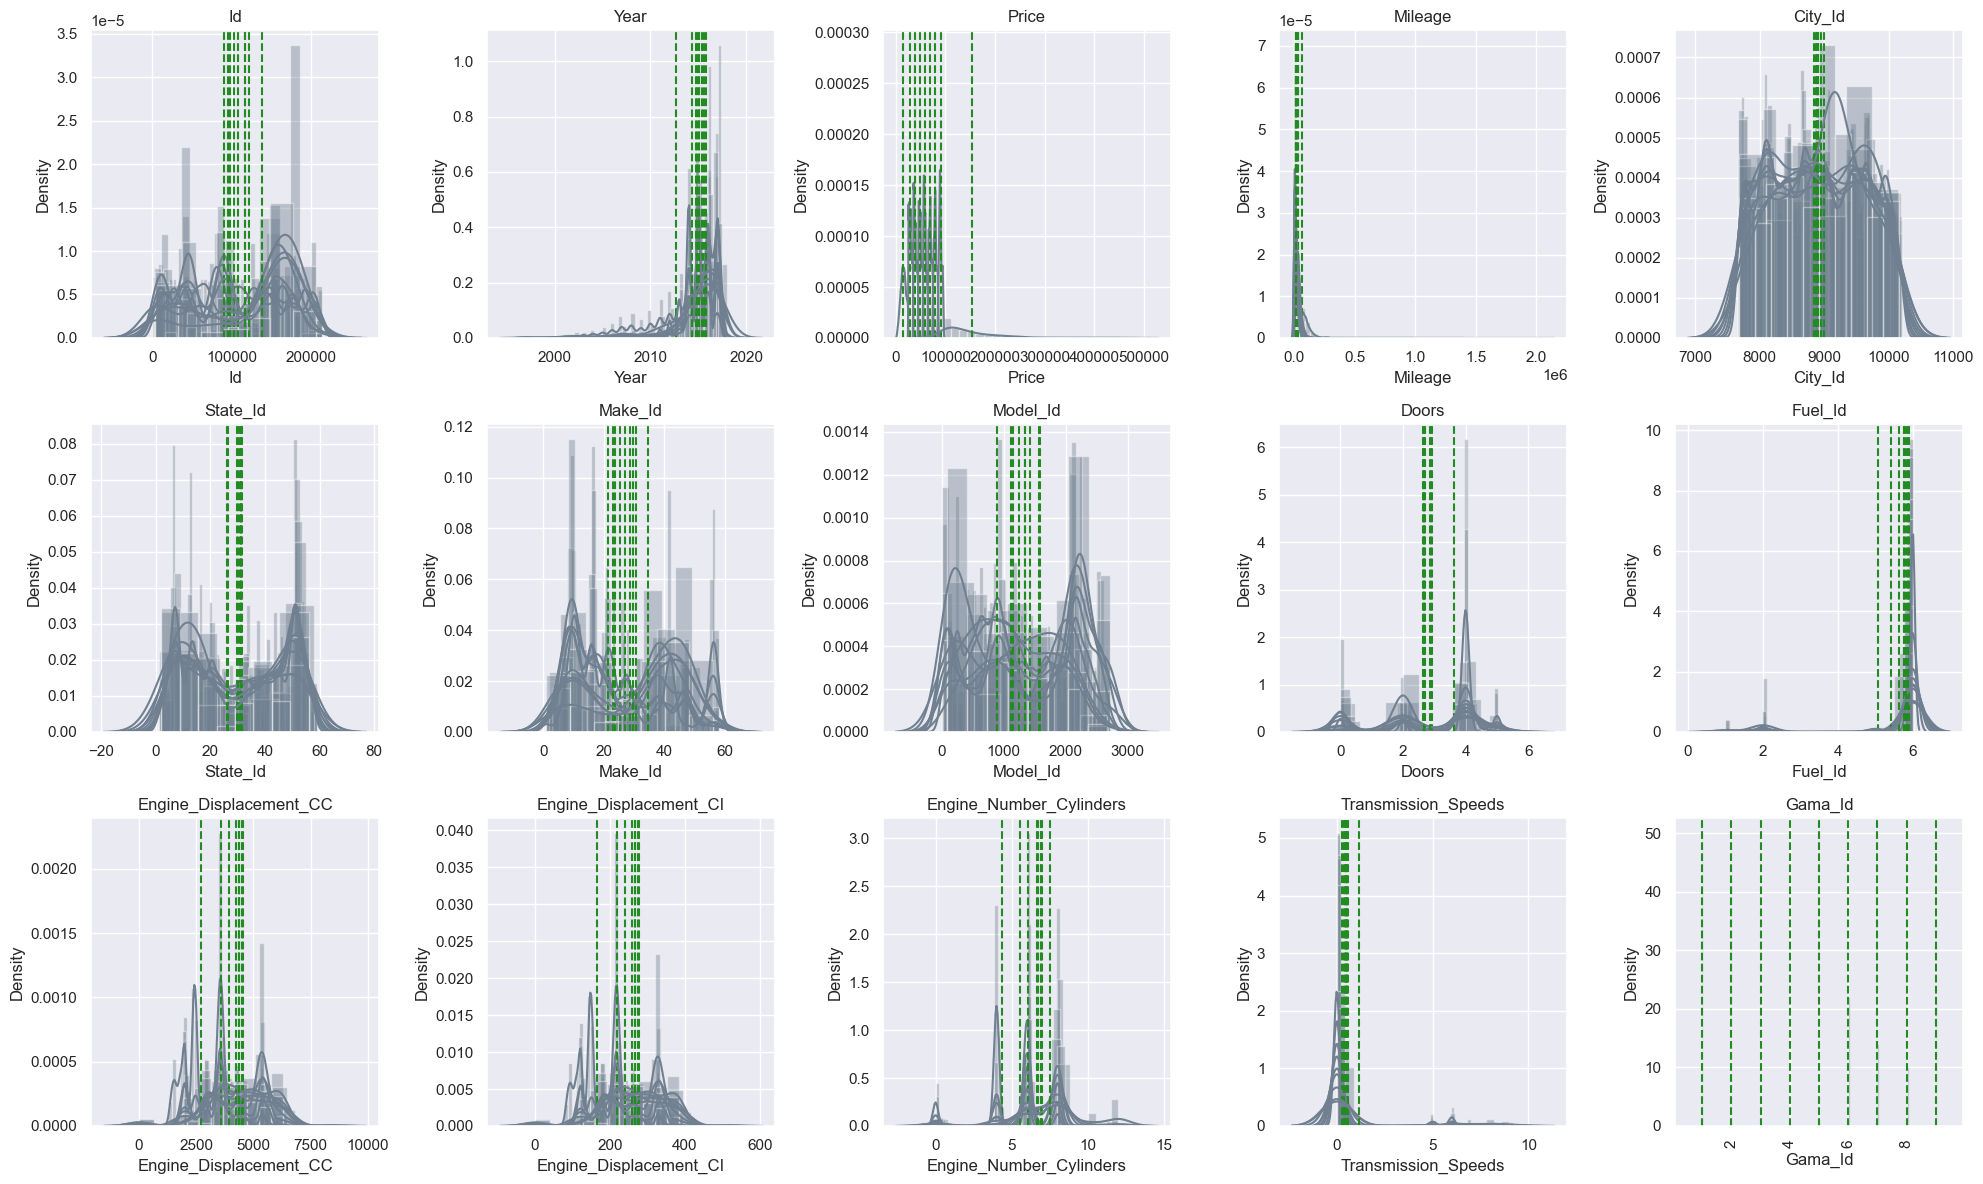

In [10]:
list_make = []
list_make = [df_test_generalista, df_test_premium1, df_test_premium2, df_test_premium3, df_test_premium4, df_test_premium5, df_test_premium6
             , df_test_premium7, df_test_premium8]

for index, value in enumerate(list_make):
    df_test_obj = value
    #df_test_obj = value[["Price"]]    
    fx.graph(df_test_obj)

<AxesSubplot:xlabel='Price', ylabel='Make'>

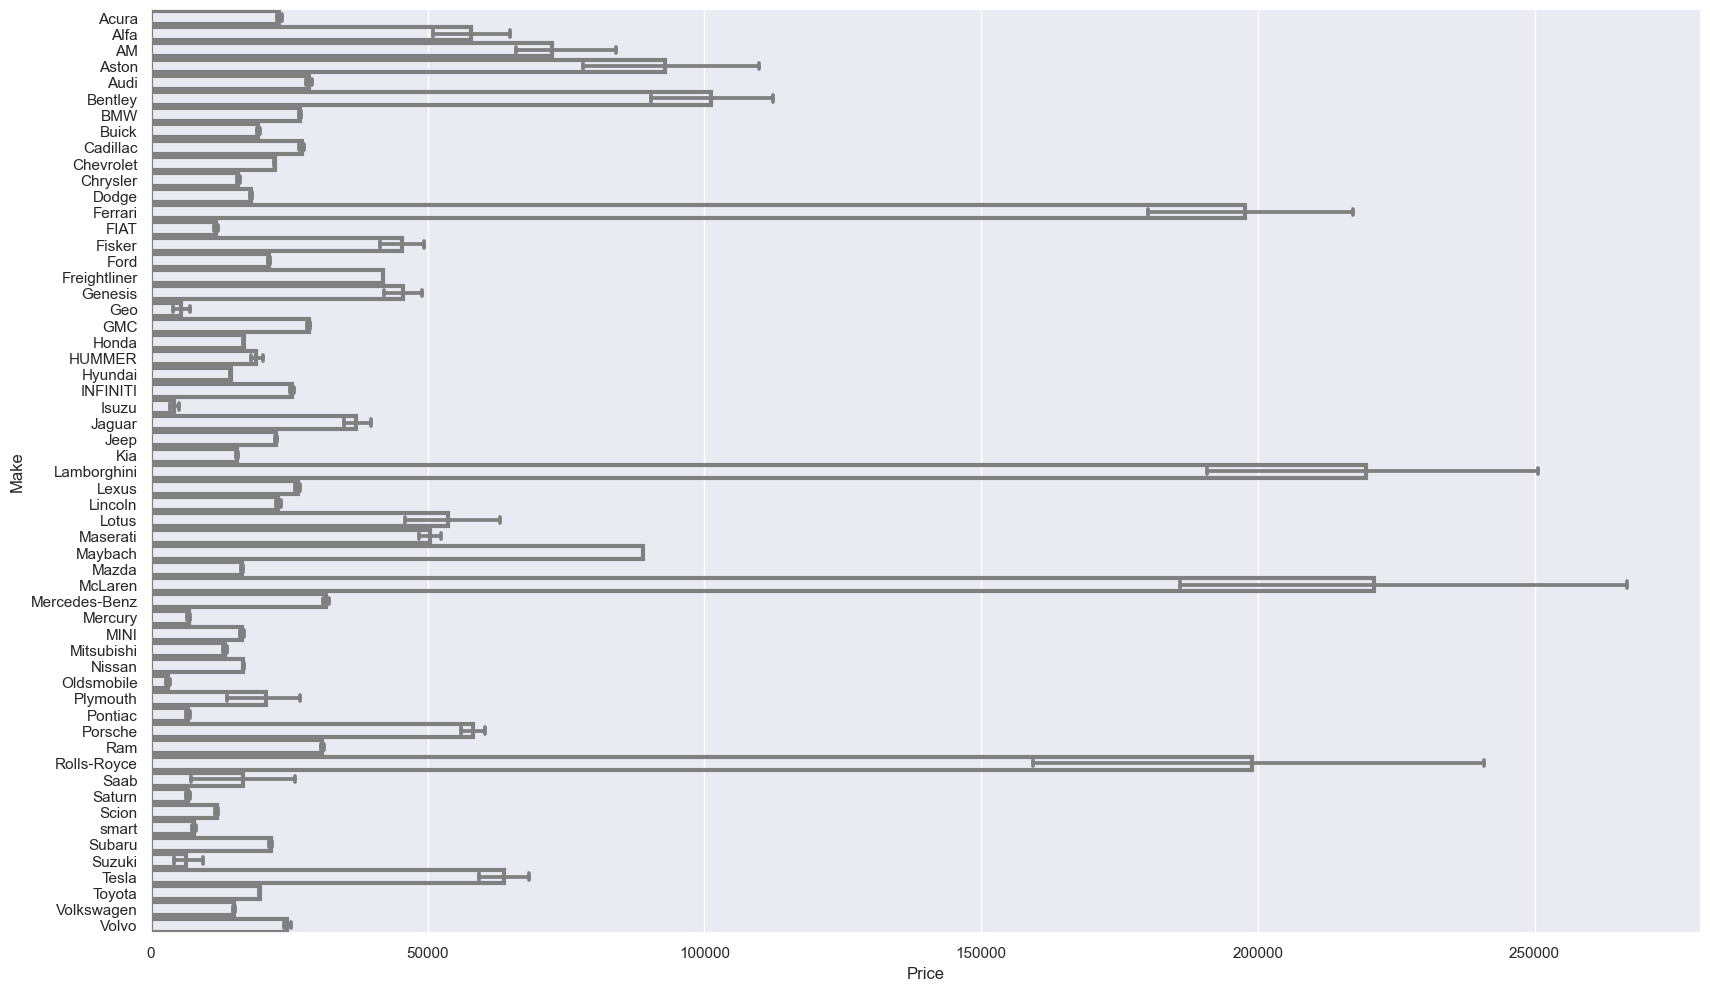

In [11]:
X = df_test.Price
Y = df_test.Make
sns.barplot(
    data=df_test, x=X, y=Y,
    capsize=.4, errcolor=".5",
    linewidth=3, edgecolor=".5", facecolor=(0, 0, 0, 0),
)

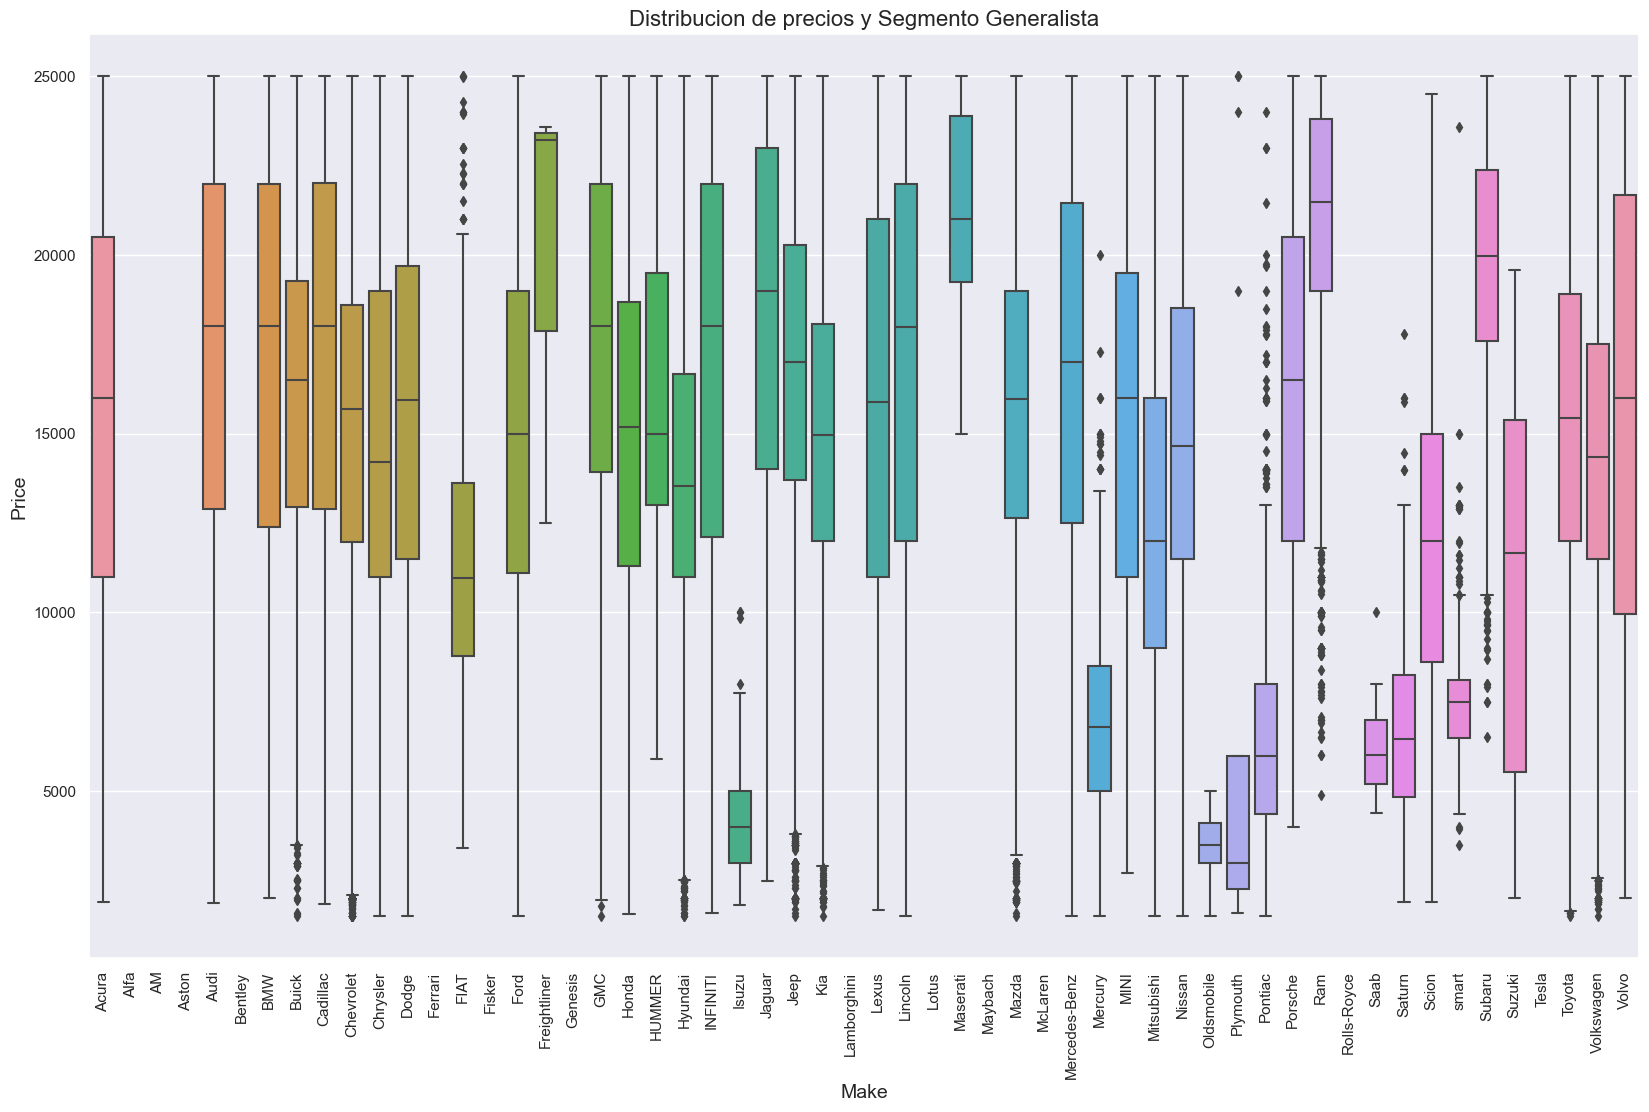

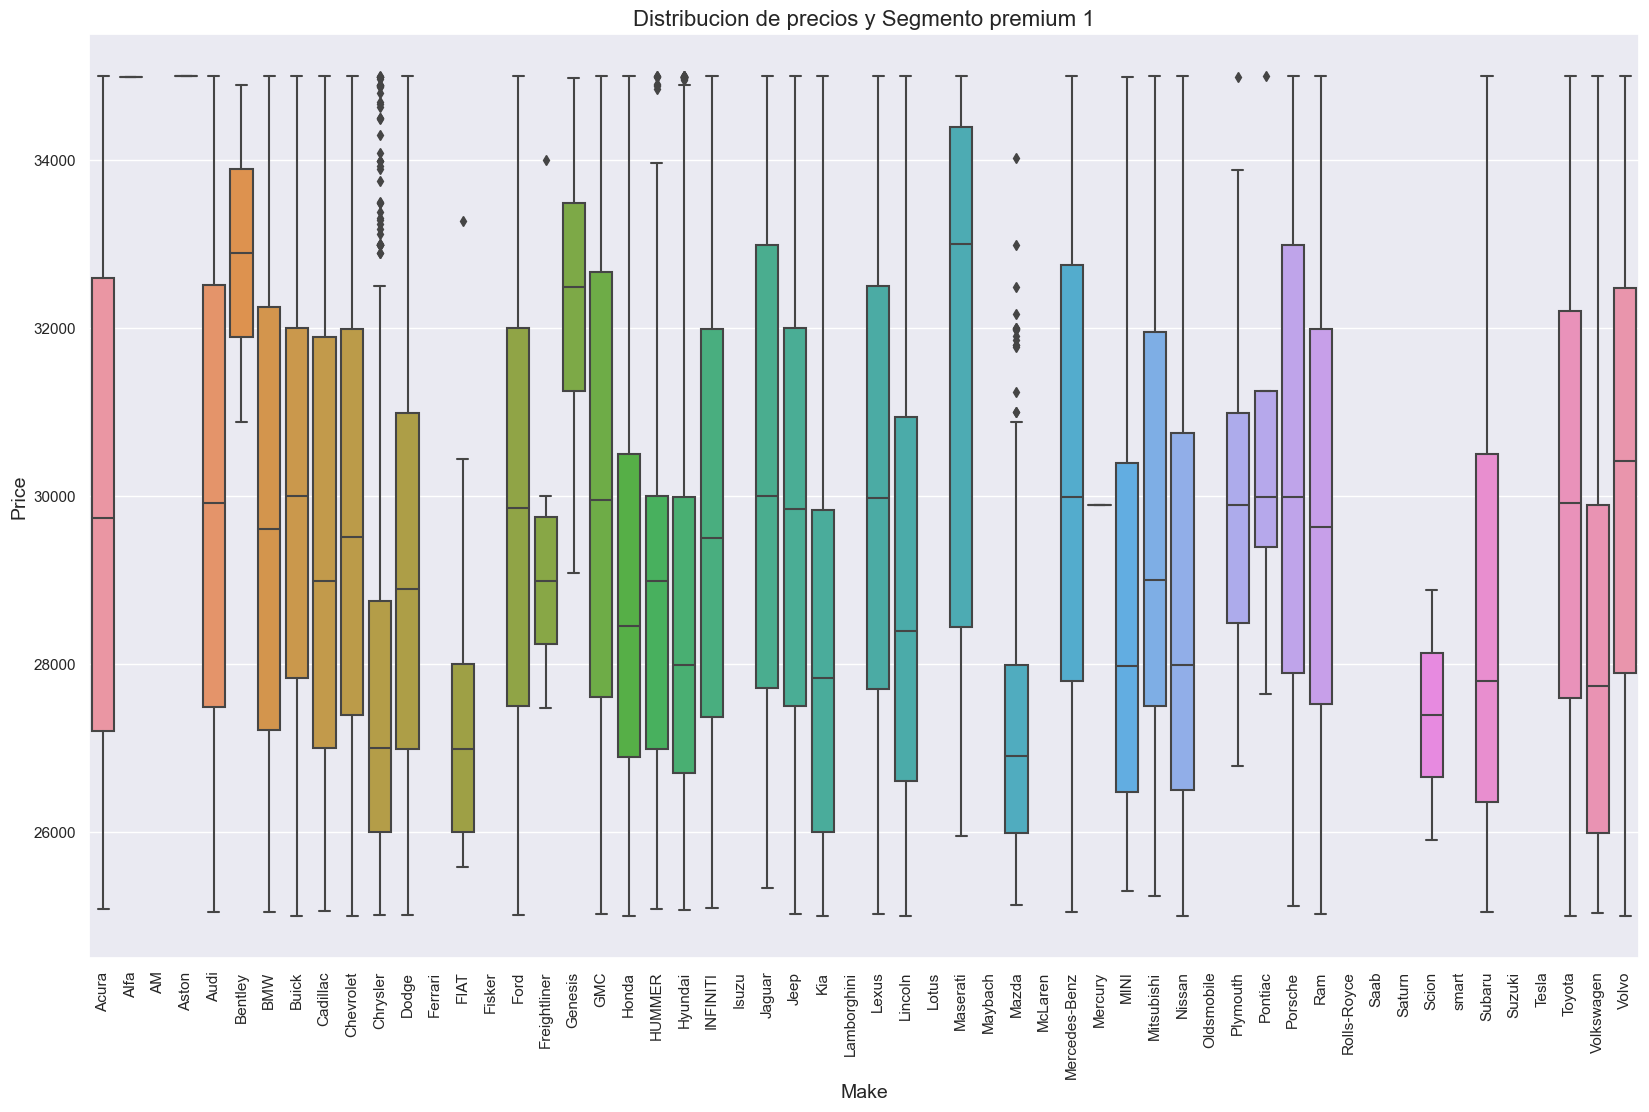

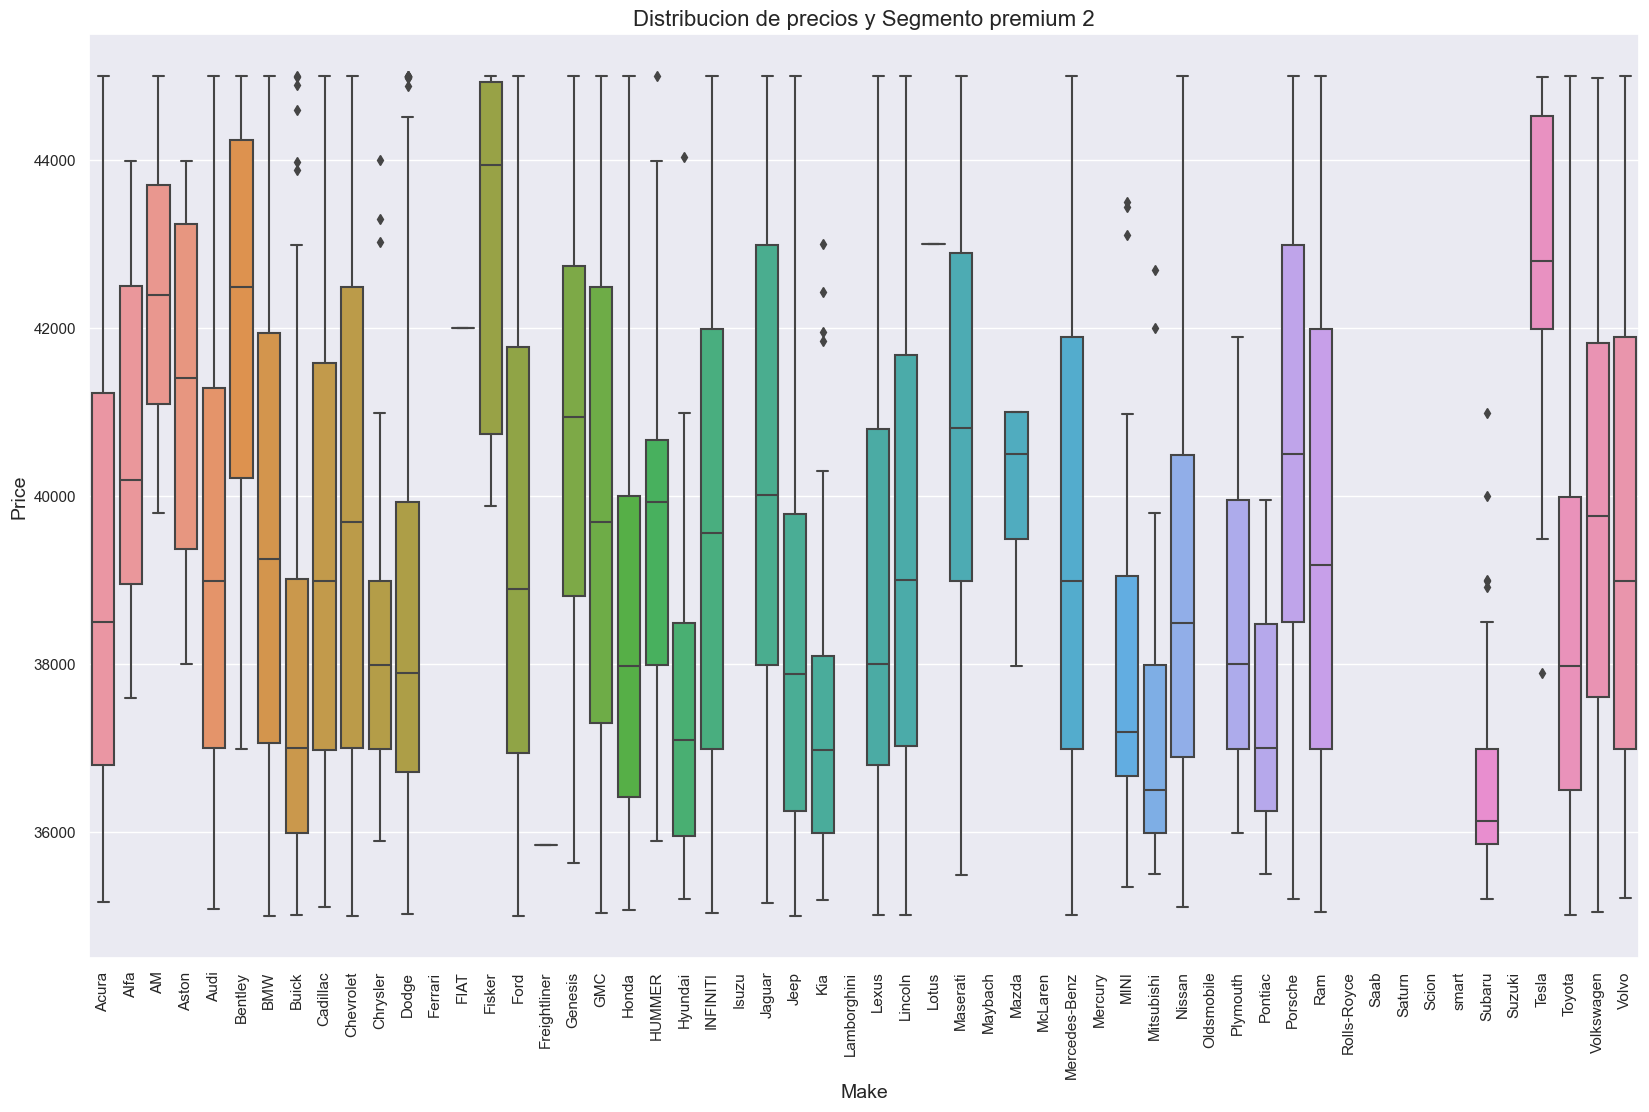

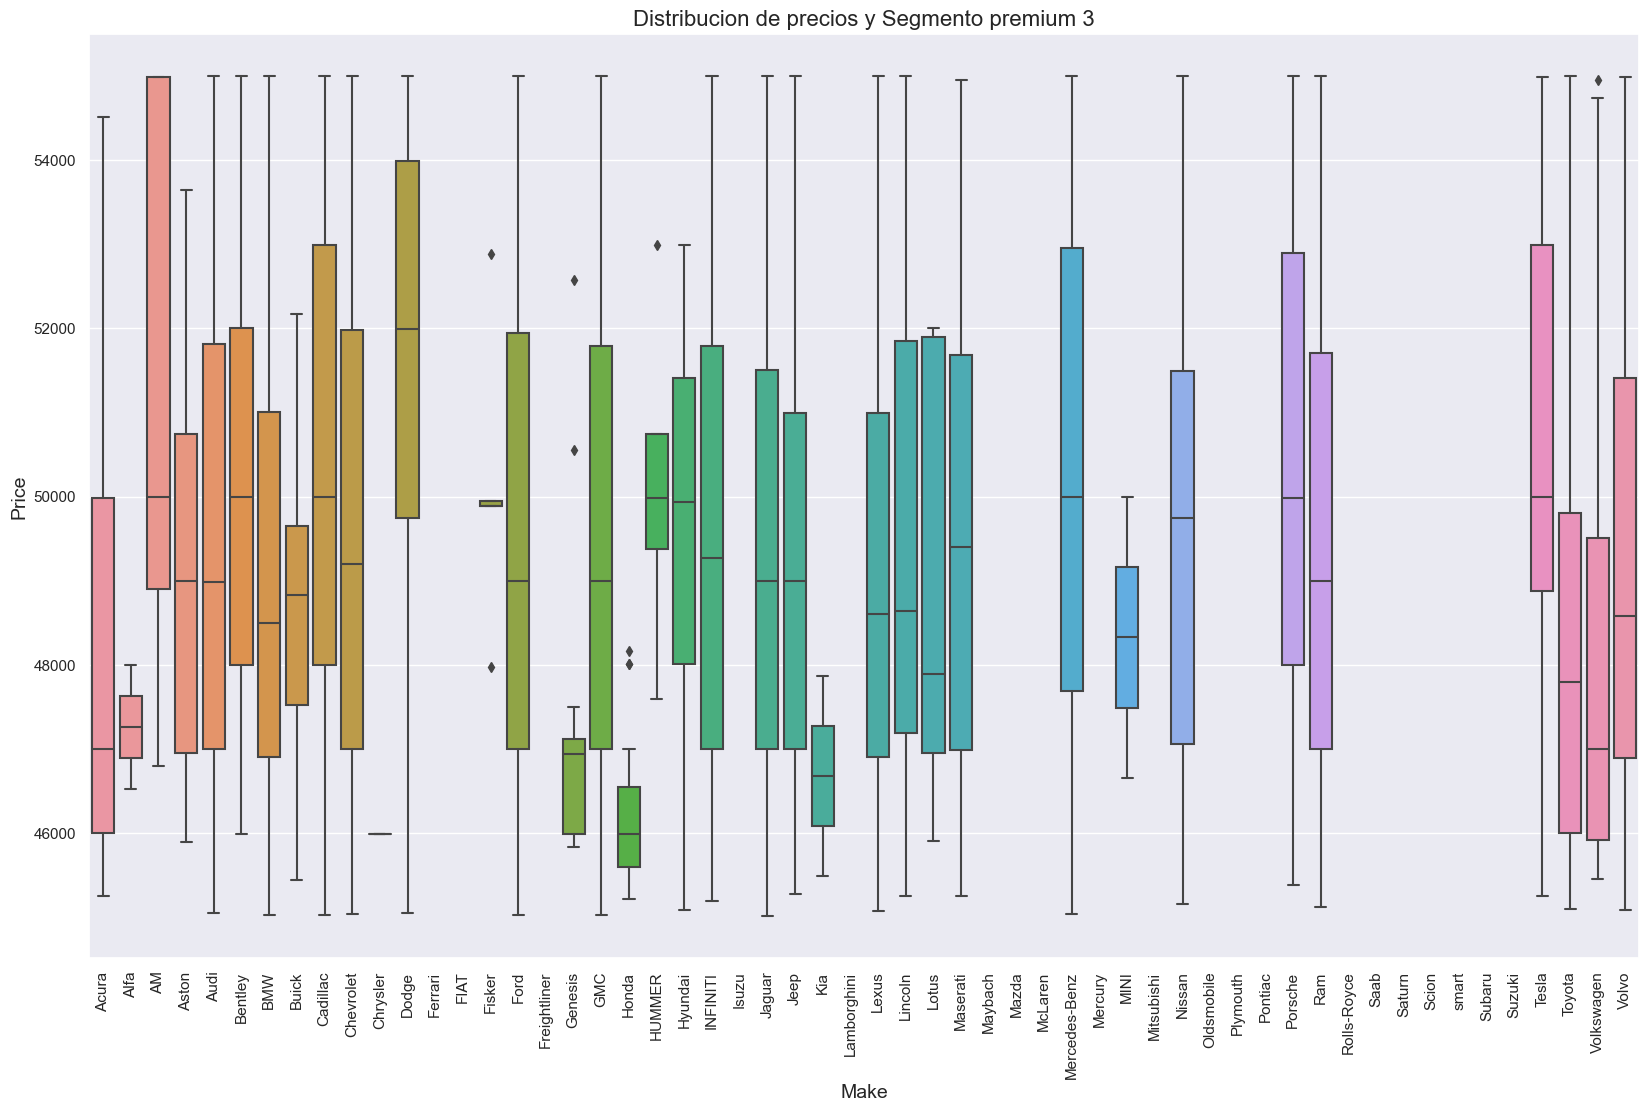

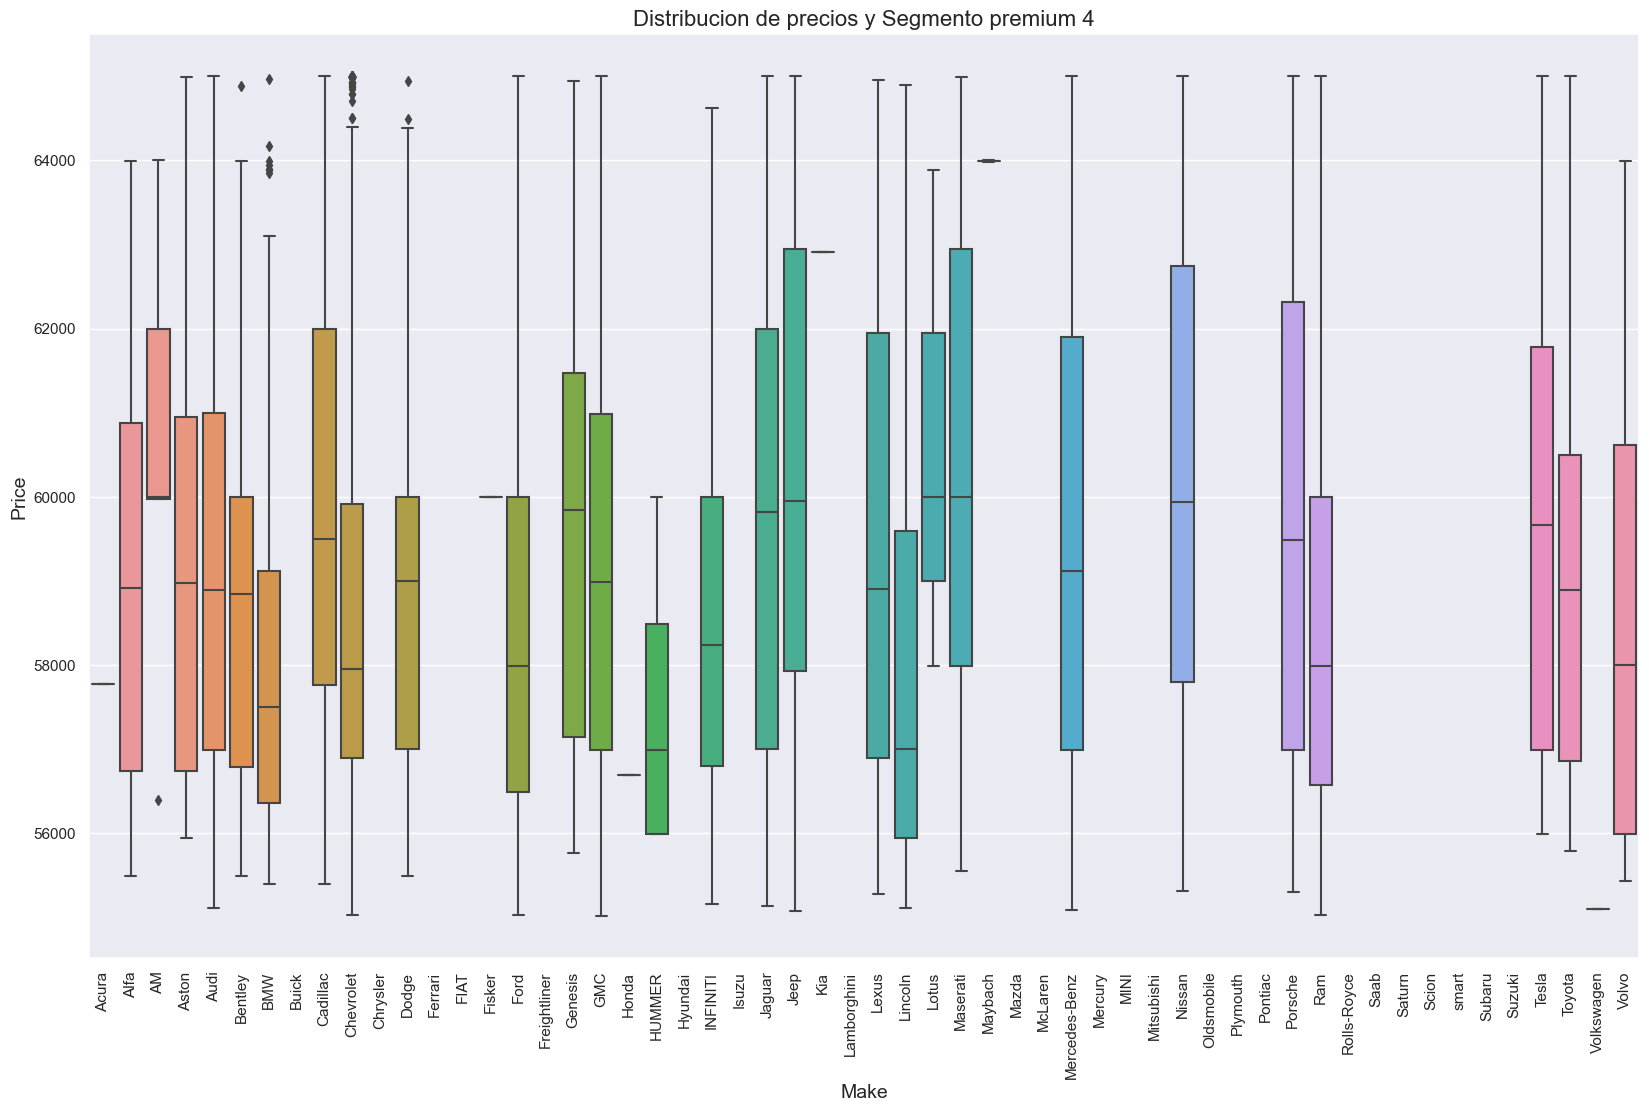

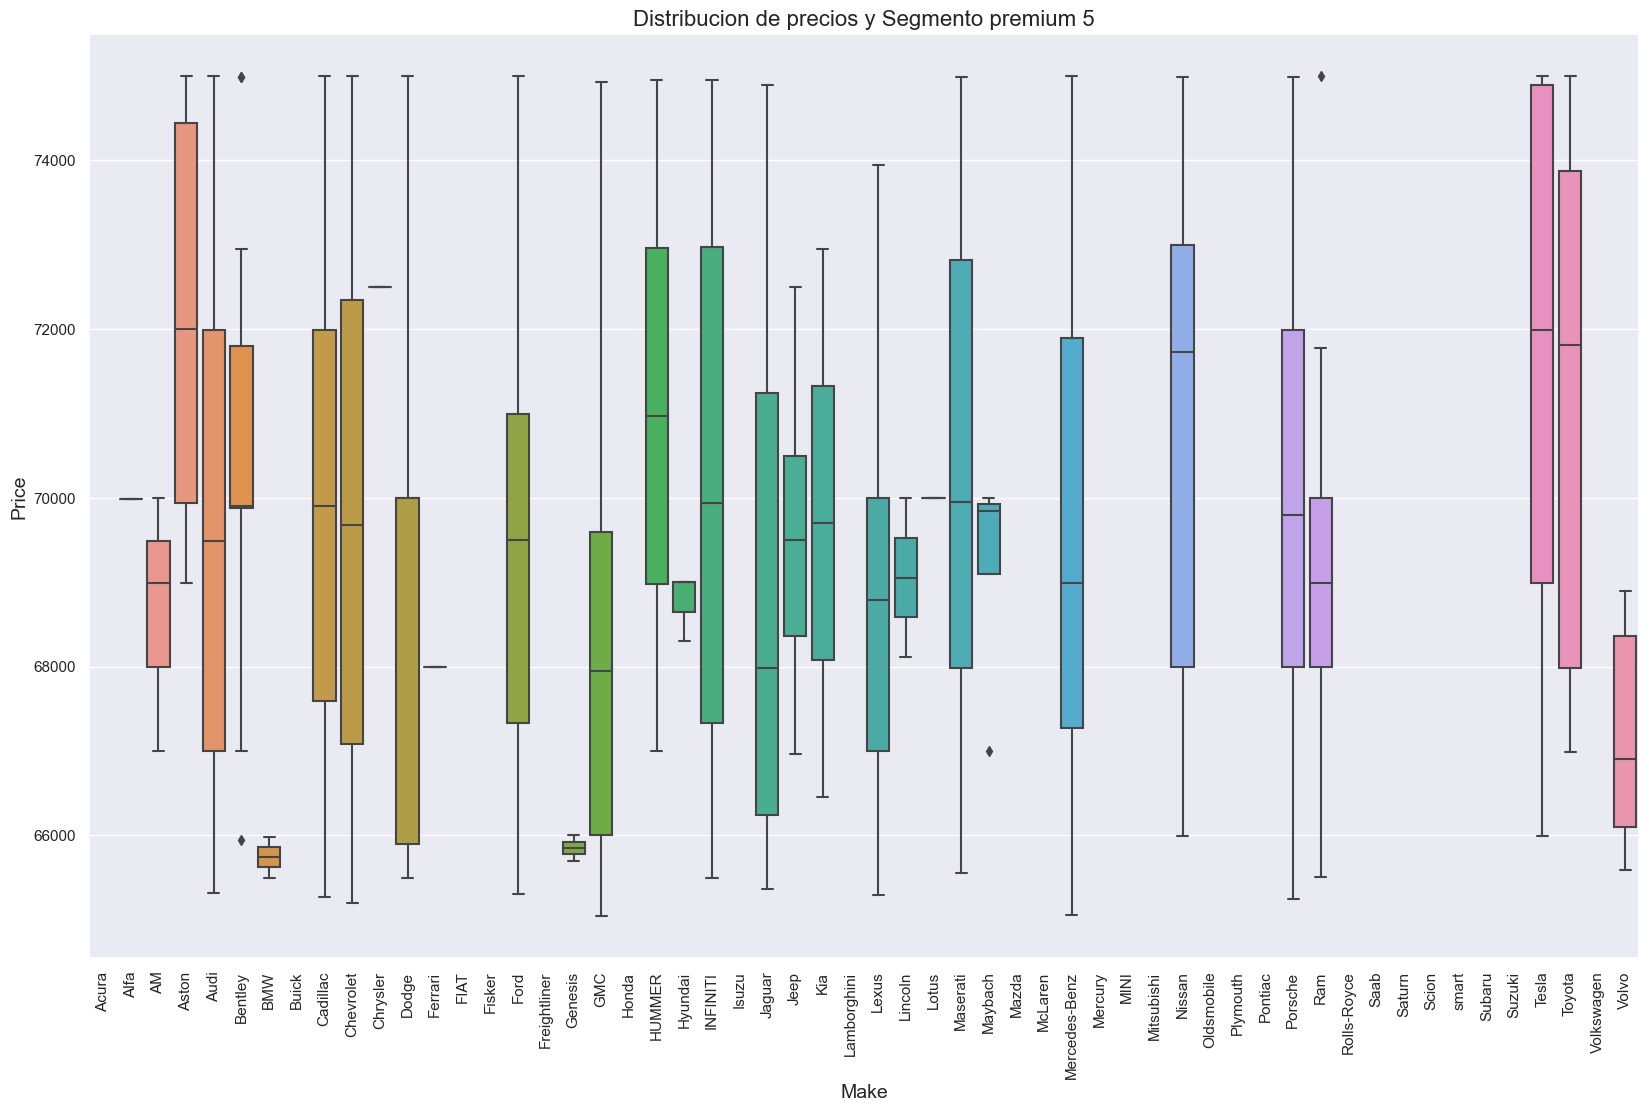

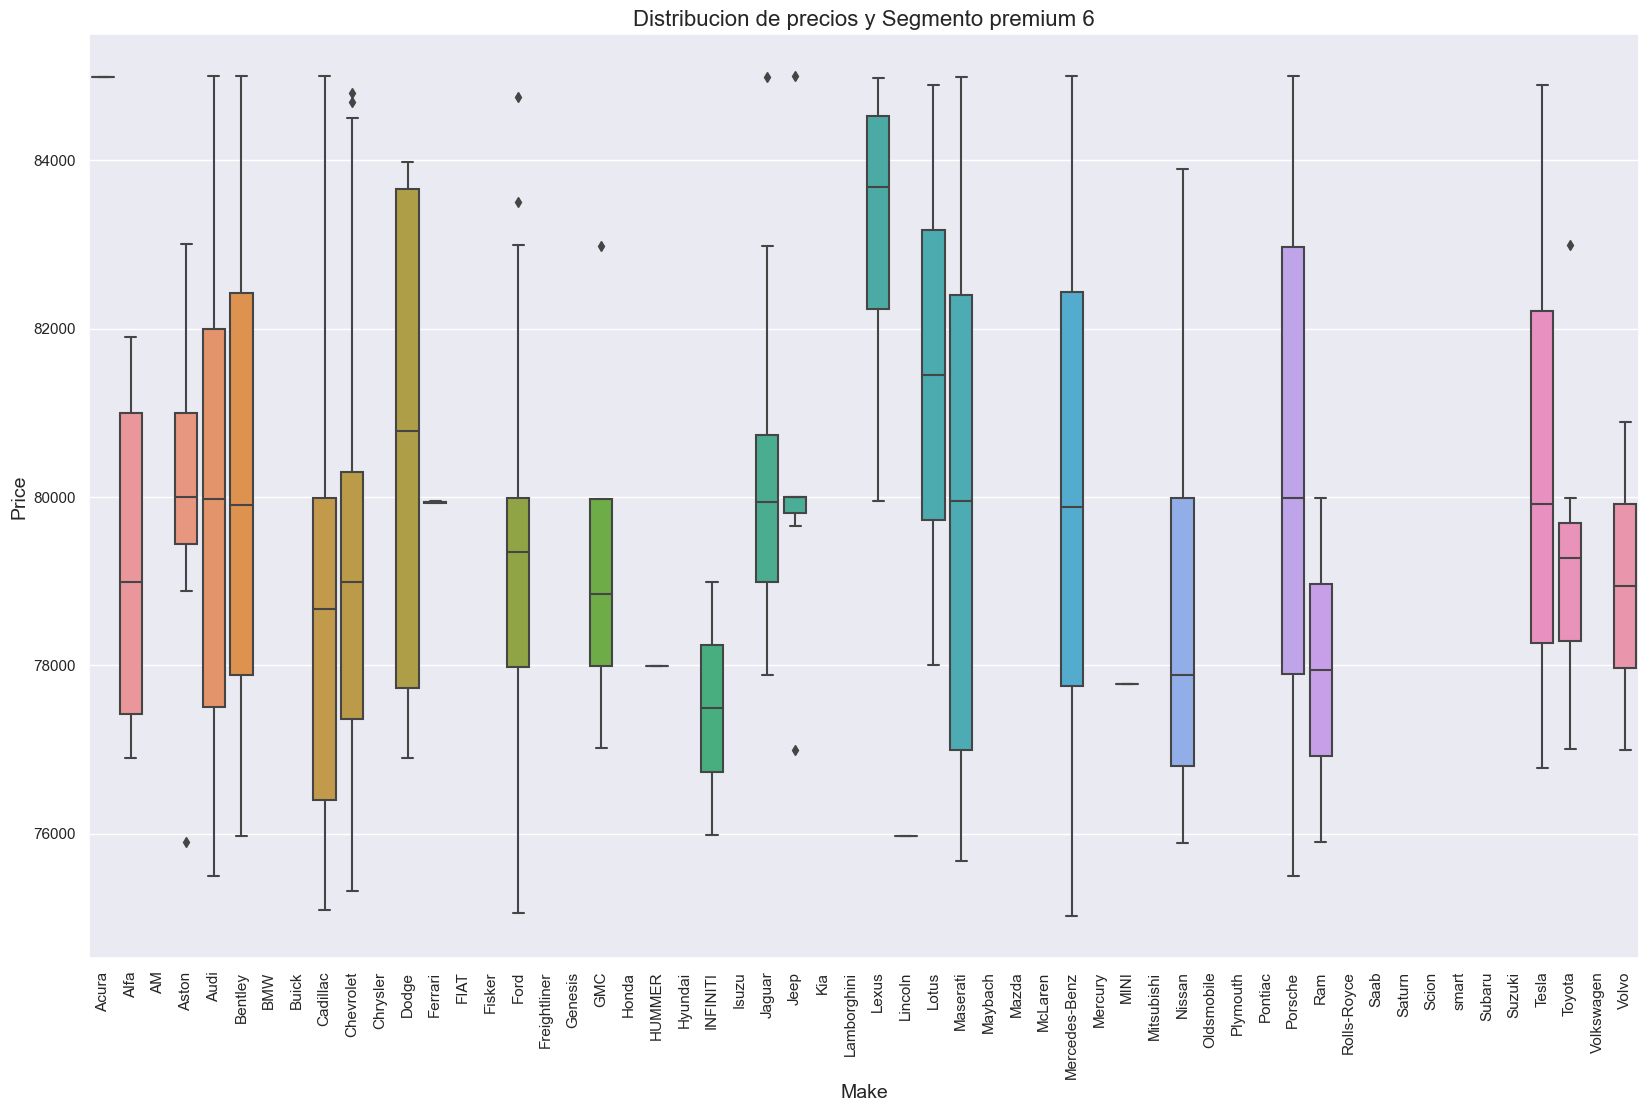

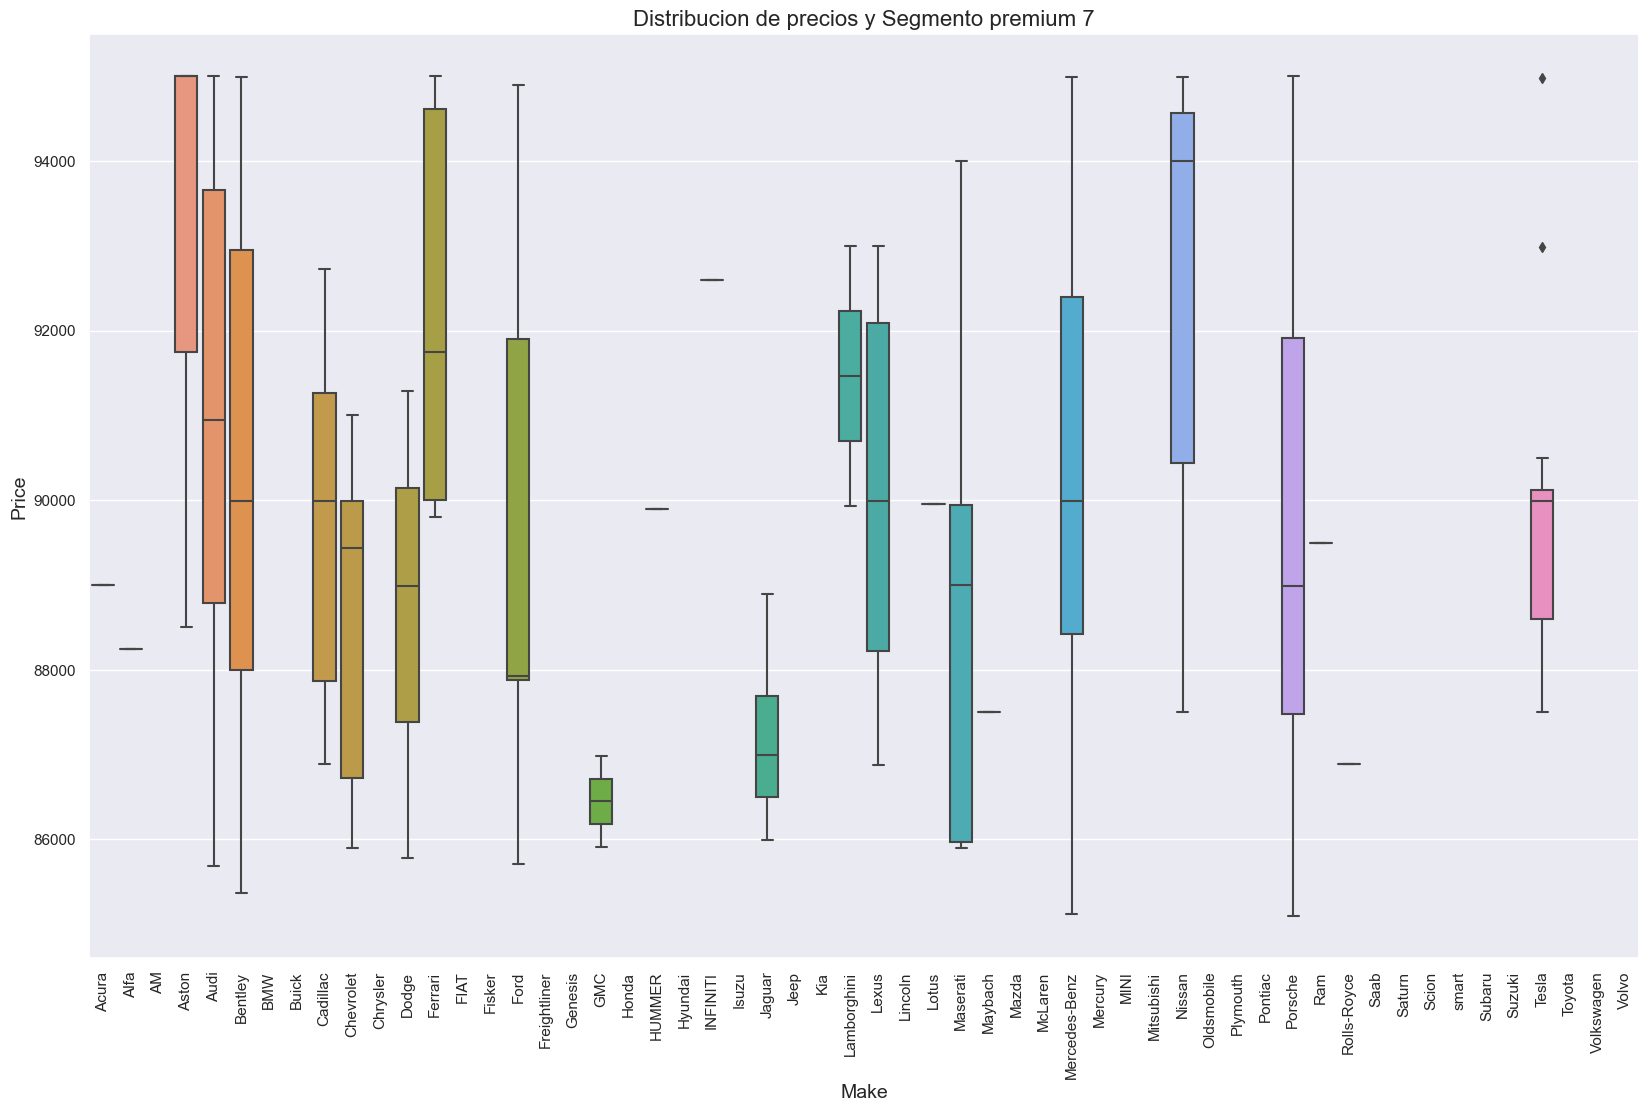

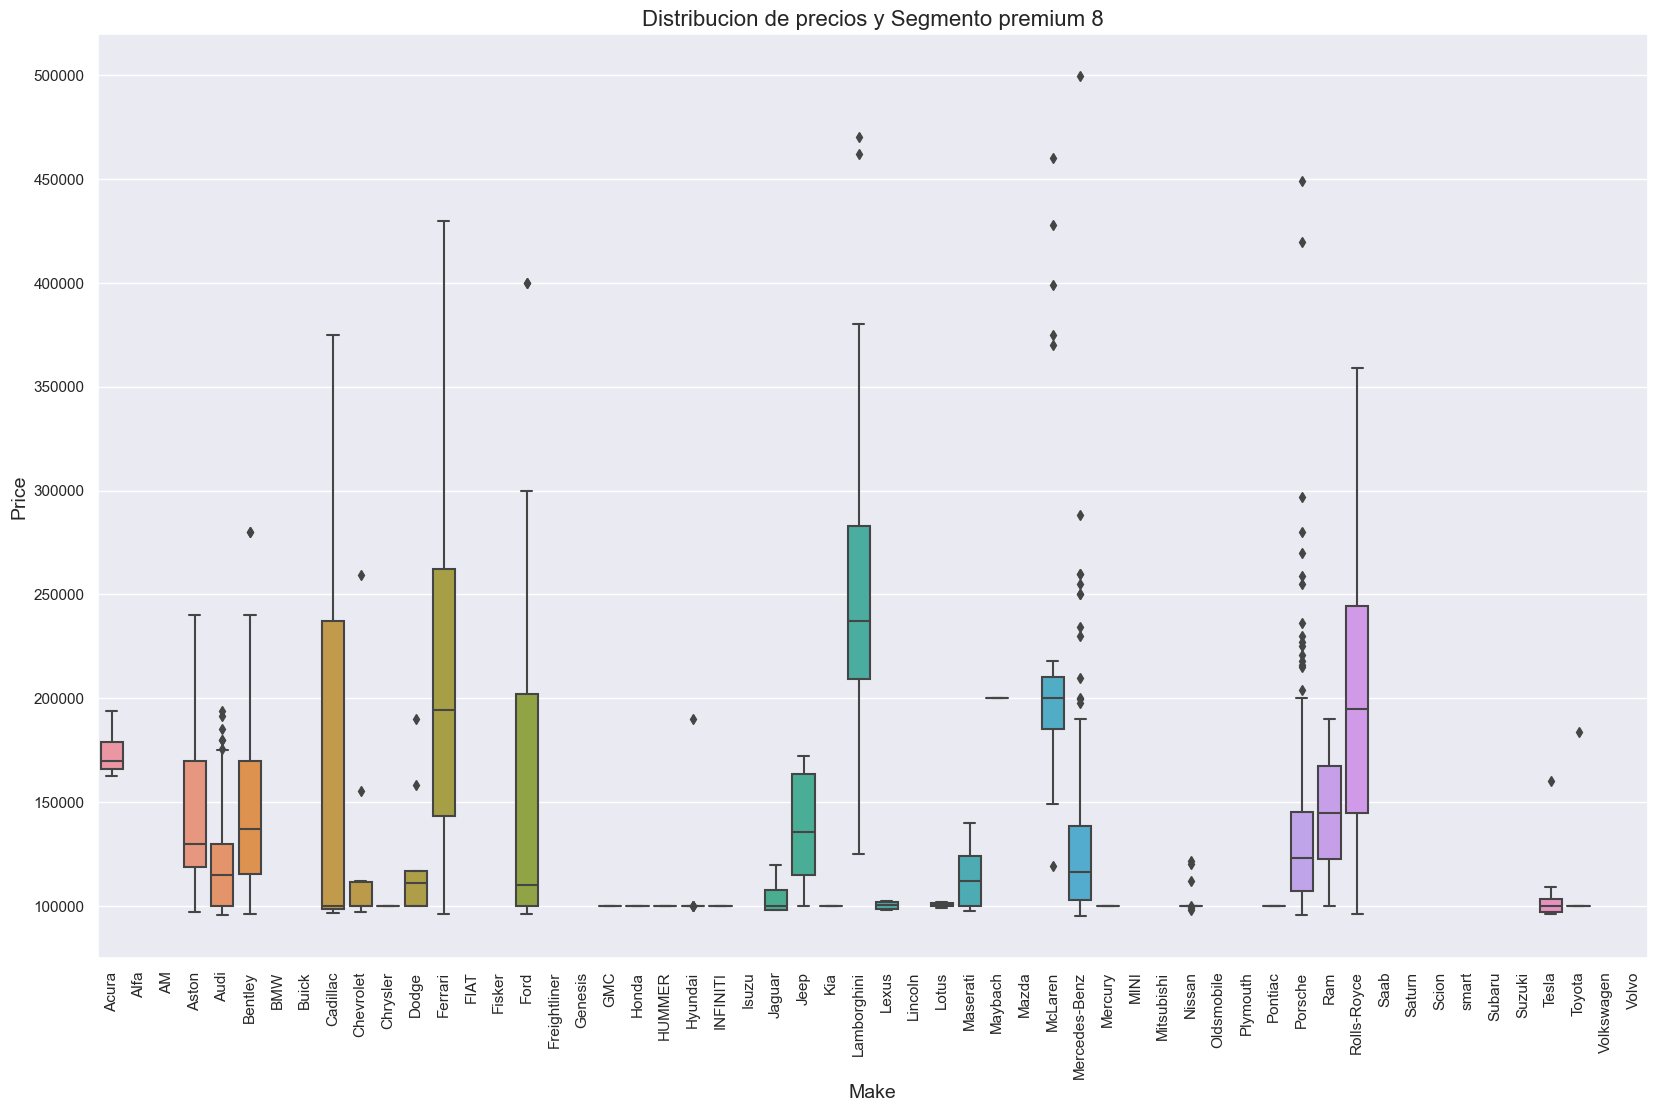

In [12]:
list_bxplot = []
list_bxplot = [df_train_generalista['Price'], df_train_premium1['Price'], df_train_premium2['Price'], df_train_premium3['Price']
               ,df_train_premium4['Price'], df_train_premium5['Price'], df_train_premium6['Price'], df_train_premium7['Price']
               ,df_train_premium8['Price']]

for index, value in enumerate(list_bxplot):
    title = ''
    if index == 0:
        title = 'Distribucion de precios y Segmento Generalista'
    else:
        title = f'Distribucion de precios y Segmento premium {index}'   

    #print(value)
    fx.boxplot_graph(df_train['Make'], value, title)

## Entrenamiento Modelos 

In [13]:
list_dt = []
list_dt = [[df_train_generalista, df_test_generalista], [df_train_premium1, df_test_premium1]
           ,[df_train_premium2, df_test_premium2], [df_train_premium3, df_test_premium3]
           ,[df_train_premium4, df_test_premium4], [df_train_premium5, df_test_premium5]
           ,[df_train_premium6, df_test_premium6], [df_train_premium7, df_test_premium7]
           ,[df_train_premium8, df_test_premium8]]

#### LazyPredict => LazyRegressor

#### se aplicara LazyRegressor de la libreria LazyPredict para ayudarnos a comprender que modelos funcionan mejor sin ningun ajuste de parametros.

In [16]:
X_train_model_lazy = df_train_premium8.drop(columns = ['Price'])
y_train_model_lazy = df_train_premium8['Price']

X_test_model_lazy = df_test_premium8.drop(columns = ['Price'])
y_test_model_lazy = df_test_premium8['Price']

reg = LazyRegressor(verbose=0,ignore_warnings=False, custom_metric=None )
models_lazyRegressor, predictions = reg.fit(X_train_model_lazy, X_test_model_lazy, y_train_model_lazy, y_test_model_lazy)

100%|██████████| 42/42 [01:06<00:00,  1.58s/it]


In [17]:
models_lazyRegressor

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
ExtraTreesRegressor,0.43,0.45,50472.73,0.39
GradientBoostingRegressor,0.42,0.44,51105.71,0.19
RandomForestRegressor,0.41,0.43,51453.67,1.12
AdaBoostRegressor,0.39,0.41,52502.21,0.12
HistGradientBoostingRegressor,0.36,0.38,53507.28,0.60
KNeighborsRegressor,0.34,0.36,54415.90,0.03
LGBMRegressor,0.34,0.36,54511.68,0.19
BaggingRegressor,0.34,0.36,54686.07,0.07
XGBRegressor,0.21,0.23,59605.83,0.26


#### GradientBoostingRegressor

In [ ]:
for index, value in enumerate(list_dt):
    title = ''
    if index == 0:
        title = 'Reporte para GradientBoostingRegressor dataset generalista'
    else:
        title = f'Reporte para GradientBoostingRegressor dataset premium {index}'    
        
    fx.report_metrics(GradientBoostingRegressor(random_state=11238), value[0], 
                  value[1], 'Price', title)
    print('=============================================================')
    print('\n')

Reporte para GradientBoostingRegressor dataset generalista
    RMSE: 3141.1884314043336
    MAE: 2012.4746159476035
    R2 Score: 0.6373257651194812


Reporte para GradientBoostingRegressor dataset premium 1
    RMSE: 3266.820773261645
    MAE: 2154.356388022057
    R2 Score: -0.33547751741999043


Reporte para GradientBoostingRegressor dataset premium 2
    RMSE: 3256.5599452807714
    MAE: 2062.097533784974
    R2 Score: -0.32099112602515234


Reporte para GradientBoostingRegressor dataset premium 3
    RMSE: 3270.747568006045
    MAE: 2137.516478577294
    R2 Score: -0.32392196087882885


Reporte para GradientBoostingRegressor dataset premium 4
    RMSE: 2808.717115271607
    MAE: 1653.8455754784954
    R2 Score: -0.10879764971321815


Reporte para GradientBoostingRegressor dataset premium 5
    RMSE: 3027.721780177051
    MAE: 2086.2094265211636
    R2 Score: -0.1839769325669014


Reporte para GradientBoostingRegressor dataset premium 6
    RMSE: 3191.0319907688026
    MAE: 2288.48

#### RandomForestRegressor

In [ ]:
for index, value in enumerate(list_dt):
    title = ''
    if index == 0:
        title = 'Reporte para RandomForestRegressor dataset generalista'
    else:
        title = f'Reporte para RandomForestRegressor dataset premium {index}'    
        
    fx.report_metrics(RandomForestRegressor(random_state=11238), value[0], 
                  value[1], 'Price', title)
    print('=============================================================')
    print('\n')

Reporte para GradientBoostingRegressor dataset generalista
    RMSE: 4436.349925557306
    MAE: 2728.8100000000004
    R2 Score: 0.27659698561976864


Reporte para GradientBoostingRegressor dataset premium 1
    RMSE: 3741.2135252624835
    MAE: 2365.040000000001
    R2 Score: -0.7515032823285557


Reporte para GradientBoostingRegressor dataset premium 2
    RMSE: 3504.1385741073677
    MAE: 2147.5699999999997
    R2 Score: -0.5294817214254217


Reporte para GradientBoostingRegressor dataset premium 3
    RMSE: 3812.181058445722
    MAE: 2564.0499999999993
    R2 Score: -0.7985204081548534


Reporte para GradientBoostingRegressor dataset premium 4
    RMSE: 2859.844912660979
    MAE: 1766.1299999999974
    R2 Score: -0.14953251478081686


Reporte para GradientBoostingRegressor dataset premium 5
    RMSE: 3271.0743959665015
    MAE: 2094.4100000000035
    R2 Score: -0.3819494406465418


Reporte para GradientBoostingRegressor dataset premium 6
    RMSE: 3202.853228777021
    MAE: 2022.18

#### AdaBoostRegressor

In [ ]:
for index, value in enumerate(list_dt):
    title = ''
    if index == 0:
        title = 'Reporte para AdaBoostRegressor dataset generalista'
    else:
        title = f'Reporte para AdaBoostRegressor dataset premium {index}'    
        
    fx.report_metrics(AdaBoostRegressor(random_state=11238), value[0], 
                  value[1], 'Price', title)
    print('=============================================================')
    print('\n')

Reporte para AdaBoostRegressor dataset generalista
    RMSE: 4011.7542990807974
    MAE: 3026.572256214715
    R2 Score: 0.4084419370008482


Reporte para AdaBoostRegressor dataset premium 1
    RMSE: 2743.7558048286733
    MAE: 2301.857370114609
    R2 Score: 0.05794365967505566


Reporte para AdaBoostRegressor dataset premium 2
    RMSE: 2779.3410936547552
    MAE: 2382.407614213196
    R2 Score: 0.03779979788899834


Reporte para AdaBoostRegressor dataset premium 3
    RMSE: 2822.3700905552537
    MAE: 2386.3644262241287
    R2 Score: 0.0141831110627898


Reporte para AdaBoostRegressor dataset premium 4
    RMSE: 2617.609075208831
    MAE: 1956.5660377358508
    R2 Score: 0.0369565746351288


Reporte para AdaBoostRegressor dataset premium 5
    RMSE: 2774.072265907792
    MAE: 2204.8044943820278
    R2 Score: 0.0060904762981101035


Reporte para AdaBoostRegressor dataset premium 6
    RMSE: 2827.4089813692685
    MAE: 2252.658482142855
    R2 Score: -0.012878880294695305


Reporte p

#### BaggingRegressor

In [ ]:
for index, value in enumerate(list_dt):
    title = ''
    if index == 0:
        title = 'Reporte para BaggingRegressor dataset generalista'
    else:
        title = f'Reporte para BaggingRegressor dataset premium {index}'    
        
    fx.report_metrics(BaggingRegressor(random_state=11238), value[0], 
                  value[1], 'Price', title)
    print('=============================================================')
    print('\n')

Reporte para BaggingRegressor dataset generalista
    RMSE: 4418.848187467434
    MAE: 2648.7999999999993
    R2 Score: 0.28229348674048726


Reporte para BaggingRegressor dataset premium 1
    RMSE: 3864.554311822151
    MAE: 2499.2999999999993
    R2 Score: -0.8688945364459593


Reporte para BaggingRegressor dataset premium 2
    RMSE: 3559.847465628533
    MAE: 2164.0999999999985
    R2 Score: -0.5784997787979758


Reporte para BaggingRegressor dataset premium 3
    RMSE: 3988.961772424441
    MAE: 2628.4000000000015
    R2 Score: -0.9691920808786201


Reporte para BaggingRegressor dataset premium 4
    RMSE: 3055.3179025247855
    MAE: 1830.9000000000015
    R2 Score: -0.31204613098488254


Reporte para BaggingRegressor dataset premium 5
    RMSE: 3372.6948515629283
    MAE: 2248.5
    R2 Score: -0.46914753399112086


Reporte para BaggingRegressor dataset premium 6
    RMSE: 3268.7231307424086
    MAE: 1918.8499999999985
    R2 Score: -0.3537439283867796


Reporte para BaggingRegre

#### ElasticNet

In [ ]:
for index, value in enumerate(list_dt):
    title = ''
    if index == 0:
        title = 'Reporte para DecisionTreeRegressor dataset generalista'
    else:
        title = f'Reporte para DecisionTreeRegressor dataset premium {index}'    
        
    fx.report_metrics(ElasticNet(random_state=11238), value[0], 
                  value[1], 'Price', title)
    print('=============================================================')
    print('\n')

Reporte para DecisionTreeRegressor dataset generalista
    RMSE: 3452.0028621028214
    MAE: 2286.881876403233
    R2 Score: 0.5620031177804372


Reporte para DecisionTreeRegressor dataset premium 1
    RMSE: 2748.2400504209604
    MAE: 2189.203878839442
    R2 Score: 0.05486185184127923


Reporte para DecisionTreeRegressor dataset premium 2
    RMSE: 2799.1804112286413
    MAE: 2388.5553379966586
    R2 Score: 0.02401413711992373


Reporte para DecisionTreeRegressor dataset premium 3
    RMSE: 2832.7005454337045
    MAE: 2397.4417331087025
    R2 Score: 0.006953318927973018


Reporte para DecisionTreeRegressor dataset premium 4
    RMSE: 2625.2689160522964
    MAE: 1956.726334239589
    R2 Score: 0.031312070539832426


Reporte para DecisionTreeRegressor dataset premium 5
    RMSE: 3001.3960019938904
    MAE: 2366.984208807058
    R2 Score: -0.16347728961256291


Reporte para DecisionTreeRegressor dataset premium 6
    RMSE: 2840.9833880895326
    MAE: 2281.6547361330013
    R2 Score: 

#### DecisionTreeRegressor

In [ ]:
#max = 1000

for index, value in enumerate(list_dt):
    title = ''
    if index == 0:
        title = 'Reporte para DecisionTreeRegressor dataset generalista'
    else:
        title = f'Reporte para DecisionTreeRegressor dataset premium {index}'    
        
    fx.report_metrics(DecisionTreeRegressor(random_state=11238), value[0], 
                  value[1], 'Price', title)
    print('=============================================================')
    print('\n')

Reporte para DecisionTreeRegressor dataset generalista
    RMSE: 5430.0844127789505
    MAE: 3505.0
    R2 Score: -0.08378188252855523


Reporte para DecisionTreeRegressor dataset premium 1
    RMSE: 4488.44535494046
    MAE: 3301.0
    R2 Score: -1.5210290401625612


Reporte para DecisionTreeRegressor dataset premium 2
    RMSE: 4291.291964116746
    MAE: 2990.0
    R2 Score: -1.29381227870849


Reporte para DecisionTreeRegressor dataset premium 3
    RMSE: 4467.712663437837
    MAE: 3089.5
    R2 Score: -1.470238010818778


Reporte para DecisionTreeRegressor dataset premium 4
    RMSE: 4034.9552987458787
    MAE: 2509.0
    R2 Score: -1.2883041637161803


Reporte para DecisionTreeRegressor dataset premium 5
    RMSE: 4139.778607800919
    MAE: 2893.0
    R2 Score: -1.2134287320938277


Reporte para DecisionTreeRegressor dataset premium 6
    RMSE: 4296.721952900902
    MAE: 3322.5
    R2 Score: -1.3391321105718945


Reporte para DecisionTreeRegressor dataset premium 7
    RMSE: 4620.

#### LinearRegression

In [ ]:
for index, value in enumerate(list_dt):
    title = ''
    if index == 0:
        title = 'Reporte para LinearRegression dataset generalista'
    else:
        title = f'Reporte para LinearRegression dataset premium {index}'    
        
    fx.report_metrics(LinearRegression(), value[0], 
                  value[1], 'Price', title)
    print('=============================================================')
    print('\n')

Reporte para LinearRegression dataset generalista
    RMSE: 3448.7577854073784
    MAE: 2278.4473949142266
    R2 Score: 0.5628262140901713


Reporte para LinearRegression dataset premium 1
    RMSE: 2756.1064492583687
    MAE: 2165.249137105071
    R2 Score: 0.049443493906003


Reporte para LinearRegression dataset premium 2
    RMSE: 2793.387091094066
    MAE: 2366.837970248089
    R2 Score: 0.02804985230673418


Reporte para LinearRegression dataset premium 3
    RMSE: 2829.9765997688814
    MAE: 2392.074315180056
    R2 Score: 0.008862242643746243


Reporte para LinearRegression dataset premium 4
    RMSE: 2623.361253588976
    MAE: 1920.606749858649
    R2 Score: 0.03271936118924512


Reporte para LinearRegression dataset premium 5
    RMSE: 3036.096480870855
    MAE: 2391.491640297463
    R2 Score: -0.19053576872600875


Reporte para LinearRegression dataset premium 6
    RMSE: 2863.168100418545
    MAE: 2191.4255085105397
    R2 Score: -0.038661282007557585


Reporte para Linear

#### LassoCV

In [ ]:
for index, value in enumerate(list_dt):
    title = ''
    if index == 0:
        title = 'Reporte para LassoCV dataset generalista'
    else:
        title = f'Reporte para LassoCV dataset premium {index}'    
        
    fx.report_metrics(LassoCV(cv=3, random_state=11238), value[0], 
                  value[1], 'Price', title)
    print('=============================================================')
    print('\n')

Reporte para LassoCV dataset generalista
    RMSE: 3870.042299878543
    MAE: 2575.8492727487464
    R2 Score: 0.44949641862029865


Reporte para LassoCV dataset premium 1
    RMSE: 2756.34689581133
    MAE: 2269.385124545388
    R2 Score: 0.04927763093274462


Reporte para LassoCV dataset premium 2
    RMSE: 2817.628027776926
    MAE: 2447.4489296098473
    R2 Score: 0.011107543922172392


Reporte para LassoCV dataset premium 3
    RMSE: 2842.6014400961008
    MAE: 2441.7016836310067
    R2 Score: -6.340131804005722e-07


Reporte para LassoCV dataset premium 4
    RMSE: 2673.2523658470914
    MAE: 1954.3775579185167
    R2 Score: -0.004421996426354324


Reporte para LassoCV dataset premium 5
    RMSE: 2772.7403219803527
    MAE: 2191.8952263134997
    R2 Score: 0.0070446792280677295


Reporte para LassoCV dataset premium 6
    RMSE: 2841.149125471068
    MAE: 2315.7309811608648
    R2 Score: -0.022747221100465786


Reporte para LassoCV dataset premium 7
    RMSE: 2653.8916641892065
  